# Training an optimized GRU model

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
!pwd
!p "/content/drive/My Drive/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content
/bin/bash: line 1: p: command not found


In [2]:
!pip install optuna

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 24 18:32:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
import joblib, numpy as np, torch, optuna, gc
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from pathlib import Path


DRIVE_PROJECT = "/content/drive/My Drive/Project 3/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

SUPER = joblib.load(DRIVE_PROJECT + "optimized_data_processing/super_data_payload.pkl")
train_df = SUPER["train_df"]
val_df = SUPER["val_df"]
FEATURE_SETS = SUPER["feature_sets"]
ALL_NUMERIC_COLS = SUPER["numeric_cols"]

CKPT_DIR = Path(DRIVE_PROJECT + "gru_ckpts")
CKPT_DIR.mkdir(exist_ok=True)


# Helper: build sliding windows
def build_windows(df, win_len, stride, feature_cols):
    data, labels = [], []
    for _, fl in df.groupby("flight_id"):
        X = fl[feature_cols].to_numpy(dtype=np.float32)
        y = fl["is_7700"].to_numpy(dtype=np.int8)  # chdanged from bool to int
        for i in range(0, len(X) - win_len + 1, stride):
            data.append(X[i : i + win_len])
            labels.append(int(y[i : i + win_len].any()))  # 1 if ANY emergency in window
    return np.stack(data), np.array(labels)


# GRU module (same as before) ---------------------------------------
class GRUClassifier(nn.Module):
    def __init__(self, n_feats, hidden, num_layers, dropout):
        super().__init__()
        self.gru = nn.GRU(
            input_size=n_feats,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(hidden, 1))

    def forward(self, x):
        # x : (B, T, F)
        _, h_n = self.gru(x)  # h_n : (num_layers, B, hidden)
        logits = self.head(h_n[-1])  # use last layer’s hidden
        return logits


def run_epoch(model, loader, train, optim=None):
    model.train(train)
    total, preds, gts = 0.0, [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logit = model(xb)
        loss = nn.functional.binary_cross_entropy_with_logits(logit, yb)
        if train:
            optim.zero_grad()
            loss.backward()
            optim.step()
        total += loss.item() * yb.size(0)
        preds.extend((torch.sigmoid(logit) > 0.5).cpu().numpy().ravel())
        gts.extend(yb.cpu().numpy().ravel())
    return total / len(loader.dataset), f1_score(gts, preds)

Running on cuda


In [5]:
# print(f"Training set size: {len(train_df)}")
# flights = train_df.flight_id.unique()
# print(len(flights), "flights in training set")
# print(len(val_df.flight_id.unique()), "flights in validation set")

# selected_flights = np.random.choice(
#     flights, size=int(len(flights) * 0.1), replace=False
# )
# print("Using", len(selected_flights), "flights for training")

# train_df = train_df[train_df.flight_id.isin(selected_flights)]
# print("Training set size:", len(train_df))

 ## 1.  Optuna objective with per-epoch logging

In [6]:
window_cache = {}


def get_windows(df, feat_key, win_len, stride):
    # Different DataFrames have different id() values
    cache_key = f"{id(df)}_{feat_key}_{win_len}_{stride}"
    if cache_key not in window_cache:
        if feat_key == "all_numeric":
            X_np, y_np = build_windows(df, win_len, stride, ALL_NUMERIC_COLS)
        else:
            X_np, y_np = build_windows(df, win_len, stride, FEATURE_SETS[feat_key])
        X_t = torch.tensor(X_np, dtype=torch.float32)
        y_t = torch.tensor(y_np, dtype=torch.float32).unsqueeze(1)
        window_cache[cache_key] = (X_t, y_t)
    return window_cache[cache_key]

In [7]:
def objective(trial: optuna.trial.Trial):
    print(f"---- Trial #{trial.number}  --  started ----------------------------")
    try:
        # -- data hyper-params
        feat_key = trial.suggest_categorical(
            "features", ["all_numeric", "baseline", "gru_delta"]
        )

        win_len = trial.suggest_categorical("win_len", [30, 60, 120])
        stride = trial.suggest_categorical("stride", [10, 20])

        X_tr, y_tr = get_windows(train_df, feat_key, win_len, stride)
        X_va, y_va = get_windows(val_df, feat_key, win_len, stride)

        BATCH = 256
        tr_loader = DataLoader(
            TensorDataset(X_tr, y_tr),
            batch_size=BATCH,
            shuffle=True,
            drop_last=True,
        )
        va_loader = DataLoader(
            TensorDataset(X_va, y_va),
            batch_size=BATCH,
            shuffle=False,
        )

        # -- model hyper-params

        hidden = trial.suggest_categorical("hidden", [64, 128, 256])
        layers = trial.suggest_int("layers", 1, 3)
        drop = trial.suggest_float("drop", 0.0, 0.4, step=0.1)

        lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)

        print(
            f"Using features: {feat_key}, win_len: {win_len}, stride: {stride}, "
            f"hidden: {hidden}, layers: {layers}, drop: {drop}, lr: {lr}"
        )

        model = GRUClassifier(X_tr.shape[2], hidden, layers, drop).to(DEVICE)

        optim = torch.optim.Adam(model.parameters(), lr=lr)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optim, mode="max", factor=0.5, patience=1
        )

        # -- training loop with logging

        lr_curve, tr_loss_curve, val_f1_curve = [], [], []

        EPOCHS = 10

        for ep in range(1, EPOCHS + 1):
            print(f"Epoch {ep}/{EPOCHS}  —  LR: {optim.param_groups[0]['lr']:.6f}")

            tr_loss, _ = run_epoch(model, tr_loader, True, optim)
            _, val_f1 = run_epoch(model, va_loader, False)
            lr_now = optim.param_groups[0]["lr"]
            lr_curve.append(float(lr_now))
            tr_loss_curve.append(float(tr_loss))
            val_f1_curve.append(float(val_f1))

            # report for pruning & Optuna dashboards
            trial.report(val_f1, ep)
            if trial.should_prune():
                print(f"Trial pruned at epoch {ep}, F1: {val_f1}")
                raise optuna.TrialPruned()
            scheduler.step(val_f1)
        ckpt_path = CKPT_DIR / f"trial_{trial.number}.pt"
        torch.save(model.state_dict(), ckpt_path)

        # save curves for later plotting
        trial.set_user_attr("lr_curve", lr_curve)
        trial.set_user_attr("train_loss_curve", tr_loss_curve)
        trial.set_user_attr("val_f1_curve", val_f1_curve)
        trial.set_user_attr("ckpt", str(ckpt_path))
        trial.set_user_attr("features", feat_key)
        trial.set_user_attr("win_len", win_len)
        trial.set_user_attr("stride", stride)

        # tidy memory
        del model, X_tr, y_tr, X_va, y_va, tr_loader, va_loader
        torch.cuda.empty_cache()
        gc.collect()

        return val_f1_curve[-1]  # final validation F1
    except Exception as e:
        print(f"Trial #{trial.number} failed with error: {e}")
        raise

 ## 2.  Launch / resume the study

In [8]:
import optuna

TRIALS = 72

optuna.logging.set_verbosity(optuna.logging.DEBUG)


# DB = "sqlite:///gru_hpo.db"
DB = f"sqlite:///{DRIVE_PROJECT}/gru_hpo.db"

study = optuna.create_study(
    study_name="gru_hpo",
    direction="maximize",
    storage=DB,
    load_if_exists=True,
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3),
)


study.optimize(objective, n_trials=TRIALS)


print("Best F1:", study.best_value)
print("Best params:", study.best_params)

[I 2025-05-24 18:32:31,467] A new study created in RDB with name: gru_hpo


---- Trial #0  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 128, layers: 2, drop: 0.2, lr: 0.0014991826835680123
Epoch 1/10  —  LR: 0.001499
Epoch 2/10  —  LR: 0.001499
Epoch 3/10  —  LR: 0.001499
Epoch 4/10  —  LR: 0.001499
Epoch 5/10  —  LR: 0.000750
Epoch 6/10  —  LR: 0.000750
Epoch 7/10  —  LR: 0.000375
Epoch 8/10  —  LR: 0.000375
Epoch 9/10  —  LR: 0.000187
Epoch 10/10  —  LR: 0.000187


[I 2025-05-24 18:33:32,834] Trial 0 finished with value: 0.59240729841083 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 128, 'layers': 2, 'drop': 0.2, 'lr': 0.0014991826835680123}. Best is trial 0 with value: 0.59240729841083.


---- Trial #1  --  started ----------------------------
Using features: gru_delta, win_len: 30, stride: 20, hidden: 128, layers: 3, drop: 0.30000000000000004, lr: 0.002505797474962122
Epoch 1/10  —  LR: 0.002506
Epoch 2/10  —  LR: 0.002506
Epoch 3/10  —  LR: 0.002506
Epoch 4/10  —  LR: 0.001253
Epoch 5/10  —  LR: 0.001253
Epoch 6/10  —  LR: 0.000626
Epoch 7/10  —  LR: 0.000626
Epoch 8/10  —  LR: 0.000313
Epoch 9/10  —  LR: 0.000313
Epoch 10/10  —  LR: 0.000157


[I 2025-05-24 18:34:13,037] Trial 1 finished with value: 0.5133005694671972 and parameters: {'features': 'gru_delta', 'win_len': 30, 'stride': 20, 'hidden': 128, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.002505797474962122}. Best is trial 0 with value: 0.59240729841083.


---- Trial #2  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 20, hidden: 64, layers: 2, drop: 0.30000000000000004, lr: 0.0009150177573060654
Epoch 1/10  —  LR: 0.000915
Epoch 2/10  —  LR: 0.000915
Epoch 3/10  —  LR: 0.000915
Epoch 4/10  —  LR: 0.000458
Epoch 5/10  —  LR: 0.000458
Epoch 6/10  —  LR: 0.000458
Epoch 7/10  —  LR: 0.000458
Epoch 8/10  —  LR: 0.000458
Epoch 9/10  —  LR: 0.000458
Epoch 10/10  —  LR: 0.000229


[I 2025-05-24 18:34:52,219] Trial 2 finished with value: 0.6069326357096141 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 20, 'hidden': 64, 'layers': 2, 'drop': 0.30000000000000004, 'lr': 0.0009150177573060654}. Best is trial 2 with value: 0.6069326357096141.


---- Trial #3  --  started ----------------------------
Using features: gru_delta, win_len: 30, stride: 10, hidden: 128, layers: 1, drop: 0.2, lr: 0.00034853056581768383
Epoch 1/10  —  LR: 0.000349
Epoch 2/10  —  LR: 0.000349
Epoch 3/10  —  LR: 0.000349
Epoch 4/10  —  LR: 0.000349
Epoch 5/10  —  LR: 0.000174
Epoch 6/10  —  LR: 0.000174
Epoch 7/10  —  LR: 0.000087
Epoch 8/10  —  LR: 0.000087
Epoch 9/10  —  LR: 0.000044
Epoch 10/10  —  LR: 0.000044


[I 2025-05-24 18:36:00,847] Trial 3 finished with value: 0.45886442641946695 and parameters: {'features': 'gru_delta', 'win_len': 30, 'stride': 10, 'hidden': 128, 'layers': 1, 'drop': 0.2, 'lr': 0.00034853056581768383}. Best is trial 2 with value: 0.6069326357096141.


---- Trial #4  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 128, layers: 1, drop: 0.0, lr: 0.0007274060065459558
Epoch 1/10  —  LR: 0.000727
Epoch 2/10  —  LR: 0.000727
Epoch 3/10  —  LR: 0.000727
Epoch 4/10  —  LR: 0.000727
Epoch 5/10  —  LR: 0.000727
Epoch 6/10  —  LR: 0.000364
Epoch 7/10  —  LR: 0.000364
Epoch 8/10  —  LR: 0.000182
Epoch 9/10  —  LR: 0.000182
Epoch 10/10  —  LR: 0.000091


[I 2025-05-24 18:36:47,591] Trial 4 finished with value: 0.5912642309695662 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 128, 'layers': 1, 'drop': 0.0, 'lr': 0.0007274060065459558}. Best is trial 2 with value: 0.6069326357096141.


---- Trial #5  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 10, hidden: 256, layers: 1, drop: 0.1, lr: 0.0018463999062270768
Epoch 1/10  —  LR: 0.001846
Epoch 2/10  —  LR: 0.001846
Epoch 3/10  —  LR: 0.001846
Epoch 4/10  —  LR: 0.000923
Epoch 5/10  —  LR: 0.000923
Epoch 6/10  —  LR: 0.000462
Epoch 7/10  —  LR: 0.000462
Epoch 8/10  —  LR: 0.000231
Epoch 9/10  —  LR: 0.000231
Epoch 10/10  —  LR: 0.000115


[I 2025-05-24 18:38:11,367] Trial 5 finished with value: 0.56912288948956 and parameters: {'features': 'all_numeric', 'win_len': 30, 'stride': 10, 'hidden': 256, 'layers': 1, 'drop': 0.1, 'lr': 0.0018463999062270768}. Best is trial 2 with value: 0.6069326357096141.


---- Trial #6  --  started ----------------------------
Using features: gru_delta, win_len: 60, stride: 20, hidden: 128, layers: 2, drop: 0.0, lr: 0.00023885327130069667
Epoch 1/10  —  LR: 0.000239
Epoch 2/10  —  LR: 0.000239
Epoch 3/10  —  LR: 0.000239


[I 2025-05-24 18:38:24,741] Trial 6 pruned. 


Trial pruned at epoch 3, F1: 0.5377649941408331
Trial #6 failed with error: 
---- Trial #7  --  started ----------------------------
Using features: baseline, win_len: 60, stride: 20, hidden: 256, layers: 2, drop: 0.0, lr: 0.0005277622486733176
Epoch 1/10  —  LR: 0.000528
Epoch 2/10  —  LR: 0.000528
Epoch 3/10  —  LR: 0.000528
Epoch 4/10  —  LR: 0.000264
Epoch 5/10  —  LR: 0.000264
Epoch 6/10  —  LR: 0.000132
Epoch 7/10  —  LR: 0.000132
Epoch 8/10  —  LR: 0.000066
Epoch 9/10  —  LR: 0.000066
Epoch 10/10  —  LR: 0.000033


[I 2025-05-24 18:39:29,193] Trial 7 finished with value: 0.5580473888580711 and parameters: {'features': 'baseline', 'win_len': 60, 'stride': 20, 'hidden': 256, 'layers': 2, 'drop': 0.0, 'lr': 0.0005277622486733176}. Best is trial 2 with value: 0.6069326357096141.


---- Trial #8  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 64, layers: 1, drop: 0.0, lr: 0.00034481735133938426
Epoch 1/10  —  LR: 0.000345
Epoch 2/10  —  LR: 0.000345
Epoch 3/10  —  LR: 0.000345
Epoch 4/10  —  LR: 0.000345
Epoch 5/10  —  LR: 0.000345
Epoch 6/10  —  LR: 0.000345
Epoch 7/10  —  LR: 0.000345
Epoch 8/10  —  LR: 0.000172
Epoch 9/10  —  LR: 0.000172
Epoch 10/10  —  LR: 0.000086


[I 2025-05-24 18:40:09,099] Trial 8 finished with value: 0.5947565543071162 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'hidden': 64, 'layers': 1, 'drop': 0.0, 'lr': 0.00034481735133938426}. Best is trial 2 with value: 0.6069326357096141.


---- Trial #9  --  started ----------------------------
Using features: gru_delta, win_len: 30, stride: 10, hidden: 256, layers: 2, drop: 0.2, lr: 0.0001133670646053326
Epoch 1/10  —  LR: 0.000113
Epoch 2/10  —  LR: 0.000113
Epoch 3/10  —  LR: 0.000113


[I 2025-05-24 18:40:38,171] Trial 9 pruned. 


Trial pruned at epoch 3, F1: 0.5197630476968644
Trial #9 failed with error: 
---- Trial #10  --  started ----------------------------
Using features: baseline, win_len: 30, stride: 10, hidden: 64, layers: 3, drop: 0.4, lr: 0.0035251692205568942
Epoch 1/10  —  LR: 0.003525
Epoch 2/10  —  LR: 0.003525
Epoch 3/10  —  LR: 0.003525


[I 2025-05-24 18:41:03,170] Trial 10 pruned. 


Trial pruned at epoch 3, F1: 0.5970329272705344
Trial #10 failed with error: 
---- Trial #11  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 64, layers: 1, drop: 0.4, lr: 0.0008465359988196493
Epoch 1/10  —  LR: 0.000847
Epoch 2/10  —  LR: 0.000847
Epoch 3/10  —  LR: 0.000847
Epoch 4/10  —  LR: 0.000847
Epoch 5/10  —  LR: 0.000423
Epoch 6/10  —  LR: 0.000423
Epoch 7/10  —  LR: 0.000212
Epoch 8/10  —  LR: 0.000212
Epoch 9/10  —  LR: 0.000106
Epoch 10/10  —  LR: 0.000106


[I 2025-05-24 18:41:40,864] Trial 11 finished with value: 0.5800460223537146 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'hidden': 64, 'layers': 1, 'drop': 0.4, 'lr': 0.0008465359988196493}. Best is trial 2 with value: 0.6069326357096141.


---- Trial #12  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.00019346807282216746
Epoch 1/10  —  LR: 0.000193
Epoch 2/10  —  LR: 0.000193
Epoch 3/10  —  LR: 0.000193
Epoch 4/10  —  LR: 0.000193
Epoch 5/10  —  LR: 0.000193
Epoch 6/10  —  LR: 0.000193
Epoch 7/10  —  LR: 0.000097
Epoch 8/10  —  LR: 0.000097
Epoch 9/10  —  LR: 0.000048
Epoch 10/10  —  LR: 0.000048


[I 2025-05-24 18:42:24,850] Trial 12 finished with value: 0.6265307870172133 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.00019346807282216746}. Best is trial 12 with value: 0.6265307870172133.


---- Trial #13  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.0001382355764544188
Epoch 1/10  —  LR: 0.000138
Epoch 2/10  —  LR: 0.000138
Epoch 3/10  —  LR: 0.000138


[I 2025-05-24 18:42:37,966] Trial 13 pruned. 


Trial pruned at epoch 3, F1: 0.6055028281085226
Trial #13 failed with error: 
---- Trial #14  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.0011876691350819562
Epoch 1/10  —  LR: 0.001188
Epoch 2/10  —  LR: 0.001188
Epoch 3/10  —  LR: 0.001188
Epoch 4/10  —  LR: 0.001188
Epoch 5/10  —  LR: 0.001188
Epoch 6/10  —  LR: 0.000594
Epoch 7/10  —  LR: 0.000594
Epoch 8/10  —  LR: 0.000297
Epoch 9/10  —  LR: 0.000297
Epoch 10/10  —  LR: 0.000297


[I 2025-05-24 18:43:36,911] Trial 14 finished with value: 0.6167756518931138 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.0011876691350819562}. Best is trial 12 with value: 0.6265307870172133.


---- Trial #15  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.00020109280552196062
Epoch 1/10  —  LR: 0.000201
Epoch 2/10  —  LR: 0.000201
Epoch 3/10  —  LR: 0.000201
Epoch 4/10  —  LR: 0.000201
Epoch 5/10  —  LR: 0.000201
Epoch 6/10  —  LR: 0.000201
Epoch 7/10  —  LR: 0.000101
Epoch 8/10  —  LR: 0.000101
Epoch 9/10  —  LR: 0.000050
Epoch 10/10  —  LR: 0.000050


[I 2025-05-24 18:44:36,480] Trial 15 finished with value: 0.6114767932489451 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.00020109280552196062}. Best is trial 12 with value: 0.6265307870172133.


---- Trial #16  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.4, lr: 0.00494201611838819
Epoch 1/10  —  LR: 0.004942
Epoch 2/10  —  LR: 0.004942
Epoch 3/10  —  LR: 0.004942


[I 2025-05-24 18:44:55,165] Trial 16 pruned. 


Trial pruned at epoch 3, F1: 0.5850730221306335
Trial #16 failed with error: 
---- Trial #17  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.1, lr: 0.0013115337177285527
Epoch 1/10  —  LR: 0.001312
Epoch 2/10  —  LR: 0.001312
Epoch 3/10  —  LR: 0.001312
Epoch 4/10  —  LR: 0.001312
Epoch 5/10  —  LR: 0.000656
Epoch 6/10  —  LR: 0.000656
Epoch 7/10  —  LR: 0.000328
Epoch 8/10  —  LR: 0.000328
Epoch 9/10  —  LR: 0.000164
Epoch 10/10  —  LR: 0.000164


[I 2025-05-24 18:45:54,904] Trial 17 finished with value: 0.577039946638998 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.1, 'lr': 0.0013115337177285527}. Best is trial 12 with value: 0.6265307870172133.


---- Trial #18  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.0004992899827996533
Epoch 1/10  —  LR: 0.000499
Epoch 2/10  —  LR: 0.000499
Epoch 3/10  —  LR: 0.000499
Epoch 4/10  —  LR: 0.000499
Epoch 5/10  —  LR: 0.000499
Epoch 6/10  —  LR: 0.000250
Epoch 7/10  —  LR: 0.000250
Epoch 8/10  —  LR: 0.000125
Epoch 9/10  —  LR: 0.000125
Epoch 10/10  —  LR: 0.000062


[I 2025-05-24 18:47:57,125] Trial 18 finished with value: 0.5795749885338634 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.0004992899827996533}. Best is trial 12 with value: 0.6265307870172133.


---- Trial #19  --  started ----------------------------
Using features: baseline, win_len: 60, stride: 20, hidden: 64, layers: 3, drop: 0.1, lr: 0.0001650272056045969
Epoch 1/10  —  LR: 0.000165
Epoch 2/10  —  LR: 0.000165
Epoch 3/10  —  LR: 0.000165


[I 2025-05-24 18:48:09,584] Trial 19 pruned. 


Trial pruned at epoch 3, F1: 0.579695634761714
Trial #19 failed with error: 
---- Trial #20  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 256, layers: 3, drop: 0.4, lr: 0.00036584761429955684
Epoch 1/10  —  LR: 0.000366
Epoch 2/10  —  LR: 0.000366
Epoch 3/10  —  LR: 0.000366
Epoch 4/10  —  LR: 0.000366
Epoch 5/10  —  LR: 0.000366
Epoch 6/10  —  LR: 0.000183
Epoch 7/10  —  LR: 0.000183
Epoch 8/10  —  LR: 0.000091
Epoch 9/10  —  LR: 0.000091
Epoch 10/10  —  LR: 0.000046


[I 2025-05-24 18:50:29,858] Trial 20 finished with value: 0.5914166350170907 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 256, 'layers': 3, 'drop': 0.4, 'lr': 0.00036584761429955684}. Best is trial 12 with value: 0.6265307870172133.


---- Trial #21  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.00021067093765608988
Epoch 1/10  —  LR: 0.000211
Epoch 2/10  —  LR: 0.000211
Epoch 3/10  —  LR: 0.000211
Epoch 4/10  —  LR: 0.000211
Epoch 5/10  —  LR: 0.000211
Epoch 6/10  —  LR: 0.000105
Epoch 7/10  —  LR: 0.000105
Epoch 8/10  —  LR: 0.000105
Epoch 9/10  —  LR: 0.000105
Epoch 10/10  —  LR: 0.000105


[I 2025-05-24 18:51:28,834] Trial 21 finished with value: 0.633571309978416 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.00021067093765608988}. Best is trial 21 with value: 0.633571309978416.


---- Trial #22  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.00010018074769951827
Epoch 1/10  —  LR: 0.000100
Epoch 2/10  —  LR: 0.000100
Epoch 3/10  —  LR: 0.000100


[I 2025-05-24 18:51:46,707] Trial 22 pruned. 


Trial pruned at epoch 3, F1: 0.6011352885525071
Trial #22 failed with error: 
---- Trial #23  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.0002581021390253056
Epoch 1/10  —  LR: 0.000258
Epoch 2/10  —  LR: 0.000258
Epoch 3/10  —  LR: 0.000258


[I 2025-05-24 18:52:04,494] Trial 23 pruned. 


Trial pruned at epoch 3, F1: 0.5903656212094958
Trial #23 failed with error: 
---- Trial #24  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 2, drop: 0.30000000000000004, lr: 0.0012067733912012062
Epoch 1/10  —  LR: 0.001207
Epoch 2/10  —  LR: 0.001207
Epoch 3/10  —  LR: 0.001207
Epoch 4/10  —  LR: 0.000603
Epoch 5/10  —  LR: 0.000603
Epoch 6/10  —  LR: 0.000302
Epoch 7/10  —  LR: 0.000302
Epoch 8/10  —  LR: 0.000151
Epoch 9/10  —  LR: 0.000151
Epoch 10/10  —  LR: 0.000075


[I 2025-05-24 18:52:54,150] Trial 24 finished with value: 0.5835211620335587 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 2, 'drop': 0.30000000000000004, 'lr': 0.0012067733912012062}. Best is trial 21 with value: 0.633571309978416.


---- Trial #25  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.0005357327159555071
Epoch 1/10  —  LR: 0.000536
Epoch 2/10  —  LR: 0.000536
Epoch 3/10  —  LR: 0.000536
Epoch 4/10  —  LR: 0.000268
Epoch 5/10  —  LR: 0.000268
Epoch 6/10  —  LR: 0.000134
Epoch 7/10  —  LR: 0.000134
Epoch 8/10  —  LR: 0.000134
Epoch 9/10  —  LR: 0.000134
Epoch 10/10  —  LR: 0.000067


[I 2025-05-24 18:53:38,441] Trial 25 finished with value: 0.6126080752119534 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.2, 'lr': 0.0005357327159555071}. Best is trial 21 with value: 0.633571309978416.


---- Trial #26  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 64, layers: 3, drop: 0.4, lr: 0.00016107243933877714
Epoch 1/10  —  LR: 0.000161
Epoch 2/10  —  LR: 0.000161
Epoch 3/10  —  LR: 0.000161
Epoch 4/10  —  LR: 0.000161
Epoch 5/10  —  LR: 0.000161
Epoch 6/10  —  LR: 0.000161
Epoch 7/10  —  LR: 0.000161
Epoch 8/10  —  LR: 0.000081
Epoch 9/10  —  LR: 0.000081
Epoch 10/10  —  LR: 0.000081


[I 2025-05-24 18:55:36,517] Trial 26 finished with value: 0.6189976384151141 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 64, 'layers': 3, 'drop': 0.4, 'lr': 0.00016107243933877714}. Best is trial 21 with value: 0.633571309978416.


---- Trial #27  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 10, hidden: 64, layers: 2, drop: 0.4, lr: 0.00017099067108851613
Epoch 1/10  —  LR: 0.000171
Epoch 2/10  —  LR: 0.000171
Epoch 3/10  —  LR: 0.000171


[I 2025-05-24 18:56:04,064] Trial 27 pruned. 


Trial pruned at epoch 3, F1: 0.6085622646771719
Trial #27 failed with error: 
---- Trial #28  --  started ----------------------------
Using features: gru_delta, win_len: 120, stride: 10, hidden: 256, layers: 3, drop: 0.4, lr: 0.00025676237899707803
Epoch 1/10  —  LR: 0.000257
Epoch 2/10  —  LR: 0.000257
Epoch 3/10  —  LR: 0.000257


[I 2025-05-24 18:57:28,376] Trial 28 pruned. 


Trial pruned at epoch 3, F1: 0.5059794196718272
Trial #28 failed with error: 
---- Trial #29  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 10, hidden: 64, layers: 2, drop: 0.4, lr: 0.00013710731654461214
Epoch 1/10  —  LR: 0.000137
Epoch 2/10  —  LR: 0.000137
Epoch 3/10  —  LR: 0.000137


[I 2025-05-24 18:57:58,311] Trial 29 pruned. 


Trial pruned at epoch 3, F1: 0.5840594693053709
Trial #29 failed with error: 
---- Trial #30  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 10, hidden: 128, layers: 2, drop: 0.30000000000000004, lr: 0.000225565809008508
Epoch 1/10  —  LR: 0.000226
Epoch 2/10  —  LR: 0.000226
Epoch 3/10  —  LR: 0.000226
Epoch 4/10  —  LR: 0.000226
Epoch 5/10  —  LR: 0.000113
Epoch 6/10  —  LR: 0.000113
Epoch 7/10  —  LR: 0.000056
Epoch 8/10  —  LR: 0.000056
Epoch 9/10  —  LR: 0.000028
Epoch 10/10  —  LR: 0.000028


[I 2025-05-24 18:59:20,783] Trial 30 finished with value: 0.6067478762622215 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 10, 'hidden': 128, 'layers': 2, 'drop': 0.30000000000000004, 'lr': 0.000225565809008508}. Best is trial 21 with value: 0.633571309978416.


---- Trial #31  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.0021938733336626056
Epoch 1/10  —  LR: 0.002194
Epoch 2/10  —  LR: 0.002194
Epoch 3/10  —  LR: 0.002194
Epoch 4/10  —  LR: 0.001097
Epoch 5/10  —  LR: 0.001097
Epoch 6/10  —  LR: 0.001097
Epoch 7/10  —  LR: 0.001097
Epoch 8/10  —  LR: 0.001097
Epoch 9/10  —  LR: 0.000548
Epoch 10/10  —  LR: 0.000548


[I 2025-05-24 19:00:19,816] Trial 31 finished with value: 0.6012722846147804 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.0021938733336626056}. Best is trial 21 with value: 0.633571309978416.


---- Trial #32  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.00017407055492004104
Epoch 1/10  —  LR: 0.000174
Epoch 2/10  —  LR: 0.000174
Epoch 3/10  —  LR: 0.000174


[I 2025-05-24 19:00:55,233] Trial 32 pruned. 


Trial pruned at epoch 3, F1: 0.610443448766802
Trial #32 failed with error: 
---- Trial #33  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.00032081566506351463
Epoch 1/10  —  LR: 0.000321
Epoch 2/10  —  LR: 0.000321
Epoch 3/10  —  LR: 0.000321
Epoch 4/10  —  LR: 0.000321
Epoch 5/10  —  LR: 0.000321
Epoch 6/10  —  LR: 0.000160
Epoch 7/10  —  LR: 0.000160
Epoch 8/10  —  LR: 0.000080
Epoch 9/10  —  LR: 0.000080
Epoch 10/10  —  LR: 0.000040


[I 2025-05-24 19:01:54,555] Trial 33 finished with value: 0.6175704077343421 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.2, 'lr': 0.00032081566506351463}. Best is trial 21 with value: 0.633571309978416.


---- Trial #34  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.00043451664598185674
Epoch 1/10  —  LR: 0.000435
Epoch 2/10  —  LR: 0.000435
Epoch 3/10  —  LR: 0.000435
Epoch 4/10  —  LR: 0.000435
Epoch 5/10  —  LR: 0.000217
Epoch 6/10  —  LR: 0.000217
Epoch 7/10  —  LR: 0.000217
Epoch 8/10  —  LR: 0.000109
Epoch 9/10  —  LR: 0.000109
Epoch 10/10  —  LR: 0.000109


[I 2025-05-24 19:02:53,809] Trial 34 finished with value: 0.6299150676313306 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.2, 'lr': 0.00043451664598185674}. Best is trial 21 with value: 0.633571309978416.


---- Trial #35  --  started ----------------------------
Using features: gru_delta, win_len: 120, stride: 10, hidden: 128, layers: 3, drop: 0.2, lr: 0.0004102492246288924
Epoch 1/10  —  LR: 0.000410
Epoch 2/10  —  LR: 0.000410
Epoch 3/10  —  LR: 0.000410


[I 2025-05-24 19:03:31,814] Trial 35 pruned. 


Trial pruned at epoch 3, F1: 0.5199073098799242
Trial #35 failed with error: 
---- Trial #36  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 20, hidden: 64, layers: 3, drop: 0.1, lr: 0.0001272809249929675
Epoch 1/10  —  LR: 0.000127
Epoch 2/10  —  LR: 0.000127
Epoch 3/10  —  LR: 0.000127


[I 2025-05-24 19:03:43,782] Trial 36 pruned. 


Trial pruned at epoch 3, F1: 0.5958883702453074
Trial #36 failed with error: 
---- Trial #37  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 128, layers: 3, drop: 0.2, lr: 0.00028195059304284454
Epoch 1/10  —  LR: 0.000282
Epoch 2/10  —  LR: 0.000282
Epoch 3/10  —  LR: 0.000282
Epoch 4/10  —  LR: 0.000282
Epoch 5/10  —  LR: 0.000282
Epoch 6/10  —  LR: 0.000282
Epoch 7/10  —  LR: 0.000141
Epoch 8/10  —  LR: 0.000141
Epoch 9/10  —  LR: 0.000070
Epoch 10/10  —  LR: 0.000070


[I 2025-05-24 19:04:52,476] Trial 37 finished with value: 0.5838458384583846 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 128, 'layers': 3, 'drop': 0.2, 'lr': 0.00028195059304284454}. Best is trial 21 with value: 0.633571309978416.


---- Trial #38  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 10, hidden: 64, layers: 3, drop: 0.2, lr: 0.0004470990375633453
Epoch 1/10  —  LR: 0.000447
Epoch 2/10  —  LR: 0.000447
Epoch 3/10  —  LR: 0.000447
Epoch 4/10  —  LR: 0.000447
Epoch 5/10  —  LR: 0.000447
Epoch 6/10  —  LR: 0.000224
Epoch 7/10  —  LR: 0.000224
Epoch 8/10  —  LR: 0.000112
Epoch 9/10  —  LR: 0.000112
Epoch 10/10  —  LR: 0.000056


[I 2025-05-24 19:06:50,749] Trial 38 finished with value: 0.5863231398988683 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 10, 'hidden': 64, 'layers': 3, 'drop': 0.2, 'lr': 0.0004470990375633453}. Best is trial 21 with value: 0.633571309978416.


---- Trial #39  --  started ----------------------------
Using features: gru_delta, win_len: 60, stride: 20, hidden: 256, layers: 2, drop: 0.4, lr: 0.0006555390030401694
Epoch 1/10  —  LR: 0.000656
Epoch 2/10  —  LR: 0.000656
Epoch 3/10  —  LR: 0.000656


[I 2025-05-24 19:07:09,820] Trial 39 pruned. 


Trial pruned at epoch 3, F1: 0.49480288416518403
Trial #39 failed with error: 
---- Trial #40  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.00019301244600819677
Epoch 1/10  —  LR: 0.000193
Epoch 2/10  —  LR: 0.000193
Epoch 3/10  —  LR: 0.000193


[I 2025-05-24 19:07:21,590] Trial 40 pruned. 


Trial pruned at epoch 3, F1: 0.6108778625954199
Trial #40 failed with error: 
---- Trial #41  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.0003347889977699518
Epoch 1/10  —  LR: 0.000335
Epoch 2/10  —  LR: 0.000335
Epoch 3/10  —  LR: 0.000335
Epoch 4/10  —  LR: 0.000335
Epoch 5/10  —  LR: 0.000335
Epoch 6/10  —  LR: 0.000335
Epoch 7/10  —  LR: 0.000167
Epoch 8/10  —  LR: 0.000167
Epoch 9/10  —  LR: 0.000084
Epoch 10/10  —  LR: 0.000084


[I 2025-05-24 19:08:20,875] Trial 41 finished with value: 0.6205642930530308 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.2, 'lr': 0.0003347889977699518}. Best is trial 21 with value: 0.633571309978416.


---- Trial #42  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.1, lr: 0.00029601708987329927
Epoch 1/10  —  LR: 0.000296
Epoch 2/10  —  LR: 0.000296
Epoch 3/10  —  LR: 0.000296
Epoch 4/10  —  LR: 0.000296
Epoch 5/10  —  LR: 0.000296
Epoch 6/10  —  LR: 0.000148
Epoch 7/10  —  LR: 0.000148
Epoch 8/10  —  LR: 0.000074
Epoch 9/10  —  LR: 0.000074
Epoch 10/10  —  LR: 0.000037


[I 2025-05-24 19:09:20,997] Trial 42 finished with value: 0.6102209478832855 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.1, 'lr': 0.00029601708987329927}. Best is trial 21 with value: 0.633571309978416.


---- Trial #43  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.00022211265793206064
Epoch 1/10  —  LR: 0.000222
Epoch 2/10  —  LR: 0.000222
Epoch 3/10  —  LR: 0.000222


[I 2025-05-24 19:09:38,812] Trial 43 pruned. 


Trial pruned at epoch 3, F1: 0.6020711391265196
Trial #43 failed with error: 
---- Trial #44  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.0006063061590505843
Epoch 1/10  —  LR: 0.000606
Epoch 2/10  —  LR: 0.000606
Epoch 3/10  —  LR: 0.000606


[I 2025-05-24 19:09:56,723] Trial 44 pruned. 


Trial pruned at epoch 3, F1: 0.6047819971870605
Trial #44 failed with error: 
---- Trial #45  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 128, layers: 3, drop: 0.30000000000000004, lr: 0.0001506556193532733
Epoch 1/10  —  LR: 0.000151
Epoch 2/10  —  LR: 0.000151
Epoch 3/10  —  LR: 0.000151


[I 2025-05-24 19:10:11,010] Trial 45 pruned. 


Trial pruned at epoch 3, F1: 0.6077582235326637
Trial #45 failed with error: 
---- Trial #46  --  started ----------------------------
Using features: baseline, win_len: 30, stride: 10, hidden: 64, layers: 2, drop: 0.2, lr: 0.0004312444144029348
Epoch 1/10  —  LR: 0.000431
Epoch 2/10  —  LR: 0.000431
Epoch 3/10  —  LR: 0.000431


[I 2025-05-24 19:10:32,562] Trial 46 pruned. 


Trial pruned at epoch 3, F1: 0.5868310598111228
Trial #46 failed with error: 
---- Trial #47  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.00035021211301315176
Epoch 1/10  —  LR: 0.000350
Epoch 2/10  —  LR: 0.000350
Epoch 3/10  —  LR: 0.000350
Epoch 4/10  —  LR: 0.000350
Epoch 5/10  —  LR: 0.000350
Epoch 6/10  —  LR: 0.000350
Epoch 7/10  —  LR: 0.000350
Epoch 8/10  —  LR: 0.000350
Epoch 9/10  —  LR: 0.000350
Epoch 10/10  —  LR: 0.000350


[I 2025-05-24 19:11:32,142] Trial 47 finished with value: 0.629800796812749 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.00035021211301315176}. Best is trial 21 with value: 0.633571309978416.


---- Trial #48  --  started ----------------------------
Using features: gru_delta, win_len: 120, stride: 20, hidden: 256, layers: 1, drop: 0.30000000000000004, lr: 0.0007741398900076421
Epoch 1/10  —  LR: 0.000774
Epoch 2/10  —  LR: 0.000774
Epoch 3/10  —  LR: 0.000774


[I 2025-05-24 19:11:53,046] Trial 48 pruned. 


Trial pruned at epoch 3, F1: 0.531629392971246
Trial #48 failed with error: 
---- Trial #49  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.00036644715790058497
Epoch 1/10  —  LR: 0.000366
Epoch 2/10  —  LR: 0.000366
Epoch 3/10  —  LR: 0.000366
Epoch 4/10  —  LR: 0.000366
Epoch 5/10  —  LR: 0.000366
Epoch 6/10  —  LR: 0.000366
Epoch 7/10  —  LR: 0.000366
Epoch 8/10  —  LR: 0.000183
Epoch 9/10  —  LR: 0.000183
Epoch 10/10  —  LR: 0.000092


[I 2025-05-24 19:12:37,682] Trial 49 finished with value: 0.619651086240948 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.00036644715790058497}. Best is trial 21 with value: 0.633571309978416.


---- Trial #50  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.0003190063719789571
Epoch 1/10  —  LR: 0.000319
Epoch 2/10  —  LR: 0.000319
Epoch 3/10  —  LR: 0.000319
Epoch 4/10  —  LR: 0.000319
Epoch 5/10  —  LR: 0.000319
Epoch 6/10  —  LR: 0.000160
Epoch 7/10  —  LR: 0.000160
Epoch 8/10  —  LR: 0.000080
Epoch 9/10  —  LR: 0.000080
Epoch 10/10  —  LR: 0.000040


[I 2025-05-24 19:13:36,999] Trial 50 finished with value: 0.6074699370868838 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.0003190063719789571}. Best is trial 21 with value: 0.633571309978416.


---- Trial #51  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.0003947569173889963
Epoch 1/10  —  LR: 0.000395
Epoch 2/10  —  LR: 0.000395
Epoch 3/10  —  LR: 0.000395
Epoch 4/10  —  LR: 0.000395
Epoch 5/10  —  LR: 0.000197
Epoch 6/10  —  LR: 0.000197
Epoch 7/10  —  LR: 0.000099
Epoch 8/10  —  LR: 0.000099
Epoch 9/10  —  LR: 0.000049
Epoch 10/10  —  LR: 0.000049


[I 2025-05-24 19:14:21,704] Trial 51 finished with value: 0.6118222584590297 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.0003947569173889963}. Best is trial 21 with value: 0.633571309978416.


---- Trial #52  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.0005257763798157722
Epoch 1/10  —  LR: 0.000526
Epoch 2/10  —  LR: 0.000526
Epoch 3/10  —  LR: 0.000526


[I 2025-05-24 19:14:35,292] Trial 52 pruned. 


Trial pruned at epoch 3, F1: 0.5923937360178971
Trial #52 failed with error: 
---- Trial #53  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.0009778782082664698
Epoch 1/10  —  LR: 0.000978
Epoch 2/10  —  LR: 0.000978
Epoch 3/10  —  LR: 0.000978
Epoch 4/10  —  LR: 0.000489
Epoch 5/10  —  LR: 0.000489
Epoch 6/10  —  LR: 0.000244
Epoch 7/10  —  LR: 0.000244
Epoch 8/10  —  LR: 0.000122
Epoch 9/10  —  LR: 0.000122
Epoch 10/10  —  LR: 0.000061


[I 2025-05-24 19:15:19,609] Trial 53 finished with value: 0.5920240280327048 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.0009778782082664698}. Best is trial 21 with value: 0.633571309978416.


---- Trial #54  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.0003523222244827183
Epoch 1/10  —  LR: 0.000352
Epoch 2/10  —  LR: 0.000352
Epoch 3/10  —  LR: 0.000352


[I 2025-05-24 19:15:33,057] Trial 54 pruned. 


Trial pruned at epoch 3, F1: 0.5767776096822995
Trial #54 failed with error: 
---- Trial #55  --  started ----------------------------
Using features: baseline, win_len: 60, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.0002018714096498403
Epoch 1/10  —  LR: 0.000202
Epoch 2/10  —  LR: 0.000202
Epoch 3/10  —  LR: 0.000202


[I 2025-05-24 19:15:45,523] Trial 55 pruned. 


Trial pruned at epoch 3, F1: 0.5717712914834067
Trial #55 failed with error: 
---- Trial #56  --  started ----------------------------
Using features: all_numeric, win_len: 30, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.00046159799762927493
Epoch 1/10  —  LR: 0.000462
Epoch 2/10  —  LR: 0.000462
Epoch 3/10  —  LR: 0.000462


[I 2025-05-24 19:15:57,317] Trial 56 pruned. 


Trial pruned at epoch 3, F1: 0.5982294217366736
Trial #56 failed with error: 
---- Trial #57  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.00027365731205208503
Epoch 1/10  —  LR: 0.000274
Epoch 2/10  —  LR: 0.000274
Epoch 3/10  —  LR: 0.000274
Epoch 4/10  —  LR: 0.000274
Epoch 5/10  —  LR: 0.000274
Epoch 6/10  —  LR: 0.000274
Epoch 7/10  —  LR: 0.000137
Epoch 8/10  —  LR: 0.000137
Epoch 9/10  —  LR: 0.000068
Epoch 10/10  —  LR: 0.000068


[I 2025-05-24 19:16:57,721] Trial 57 finished with value: 0.619567013716741 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.00027365731205208503}. Best is trial 21 with value: 0.633571309978416.


---- Trial #58  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 64, layers: 3, drop: 0.1, lr: 0.0002325496033859159
Epoch 1/10  —  LR: 0.000233
Epoch 2/10  —  LR: 0.000233
Epoch 3/10  —  LR: 0.000233


[I 2025-05-24 19:17:11,279] Trial 58 pruned. 


Trial pruned at epoch 3, F1: 0.5719253294289898
Trial #58 failed with error: 
---- Trial #59  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 256, layers: 3, drop: 0.30000000000000004, lr: 0.0005862070919511861
Epoch 1/10  —  LR: 0.000586
Epoch 2/10  —  LR: 0.000586
Epoch 3/10  —  LR: 0.000586
Epoch 4/10  —  LR: 0.000293
Epoch 5/10  —  LR: 0.000293
Epoch 6/10  —  LR: 0.000147
Epoch 7/10  —  LR: 0.000147
Epoch 8/10  —  LR: 0.000073
Epoch 9/10  —  LR: 0.000073
Epoch 10/10  —  LR: 0.000037


[I 2025-05-24 19:19:33,169] Trial 59 finished with value: 0.5605969249321676 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 256, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.0005862070919511861}. Best is trial 21 with value: 0.633571309978416.


---- Trial #60  --  started ----------------------------
Using features: all_numeric, win_len: 60, stride: 20, hidden: 64, layers: 2, drop: 0.2, lr: 0.0003794509011797941
Epoch 1/10  —  LR: 0.000379
Epoch 2/10  —  LR: 0.000379
Epoch 3/10  —  LR: 0.000379
Epoch 4/10  —  LR: 0.000379
Epoch 5/10  —  LR: 0.000379
Epoch 6/10  —  LR: 0.000190
Epoch 7/10  —  LR: 0.000190
Epoch 8/10  —  LR: 0.000095
Epoch 9/10  —  LR: 0.000095
Epoch 10/10  —  LR: 0.000047


[I 2025-05-24 19:20:13,950] Trial 60 finished with value: 0.6152597402597403 and parameters: {'features': 'all_numeric', 'win_len': 60, 'stride': 20, 'hidden': 64, 'layers': 2, 'drop': 0.2, 'lr': 0.0003794509011797941}. Best is trial 21 with value: 0.633571309978416.


---- Trial #61  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.00027547644820451146
Epoch 1/10  —  LR: 0.000275
Epoch 2/10  —  LR: 0.000275
Epoch 3/10  —  LR: 0.000275
Epoch 4/10  —  LR: 0.000275
Epoch 5/10  —  LR: 0.000275
Epoch 6/10  —  LR: 0.000275
Epoch 7/10  —  LR: 0.000275
Epoch 8/10  —  LR: 0.000138
Epoch 9/10  —  LR: 0.000138
Epoch 10/10  —  LR: 0.000069


[I 2025-05-24 19:21:13,647] Trial 61 finished with value: 0.6297810921337503 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.00027547644820451146}. Best is trial 21 with value: 0.633571309978416.


---- Trial #62  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.0003516473800337228
Epoch 1/10  —  LR: 0.000352
Epoch 2/10  —  LR: 0.000352
Epoch 3/10  —  LR: 0.000352


[I 2025-05-24 19:21:31,584] Trial 62 pruned. 


Trial pruned at epoch 3, F1: 0.6157807614493287
Trial #62 failed with error: 
---- Trial #63  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.0002985303274463985
Epoch 1/10  —  LR: 0.000299
Epoch 2/10  —  LR: 0.000299
Epoch 3/10  —  LR: 0.000299
Epoch 4/10  —  LR: 0.000299
Epoch 5/10  —  LR: 0.000299
Epoch 6/10  —  LR: 0.000149
Epoch 7/10  —  LR: 0.000149
Epoch 8/10  —  LR: 0.000149
Epoch 9/10  —  LR: 0.000149
Epoch 10/10  —  LR: 0.000075


[I 2025-05-24 19:22:31,075] Trial 63 finished with value: 0.6398239465319097 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.30000000000000004, 'lr': 0.0002985303274463985}. Best is trial 63 with value: 0.6398239465319097.


---- Trial #64  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 1, drop: 0.30000000000000004, lr: 0.0002481053658448939
Epoch 1/10  —  LR: 0.000248
Epoch 2/10  —  LR: 0.000248
Epoch 3/10  —  LR: 0.000248


[I 2025-05-24 19:22:44,326] Trial 64 pruned. 


Trial pruned at epoch 3, F1: 0.5957363583023665
Trial #64 failed with error: 
---- Trial #65  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.0001905435868910783
Epoch 1/10  —  LR: 0.000191
Epoch 2/10  —  LR: 0.000191
Epoch 3/10  —  LR: 0.000191


[I 2025-05-24 19:23:02,226] Trial 65 pruned. 


Trial pruned at epoch 3, F1: 0.6067026194144838
Trial #65 failed with error: 
---- Trial #66  --  started ----------------------------
Using features: baseline, win_len: 120, stride: 20, hidden: 128, layers: 3, drop: 0.2, lr: 0.0003228530339846622
Epoch 1/10  —  LR: 0.000323
Epoch 2/10  —  LR: 0.000323
Epoch 3/10  —  LR: 0.000323


[I 2025-05-24 19:23:21,509] Trial 66 pruned. 


Trial pruned at epoch 3, F1: 0.5861746450131792
Trial #66 failed with error: 
---- Trial #67  --  started ----------------------------
Using features: gru_delta, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.4, lr: 0.0002879646517203978
Epoch 1/10  —  LR: 0.000288
Epoch 2/10  —  LR: 0.000288
Epoch 3/10  —  LR: 0.000288


[I 2025-05-24 19:23:38,138] Trial 67 pruned. 


Trial pruned at epoch 3, F1: 0.5315196426758705
Trial #67 failed with error: 
---- Trial #68  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.00011516045028354148
Epoch 1/10  —  LR: 0.000115
Epoch 2/10  —  LR: 0.000115
Epoch 3/10  —  LR: 0.000115


[I 2025-05-24 19:23:55,948] Trial 68 pruned. 


Trial pruned at epoch 3, F1: 0.5915245981490501
Trial #68 failed with error: 
---- Trial #69  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.30000000000000004, lr: 0.0002239797360725492
Epoch 1/10  —  LR: 0.000224
Epoch 2/10  —  LR: 0.000224
Epoch 3/10  —  LR: 0.000224


[I 2025-05-24 19:24:14,024] Trial 69 pruned. 


Trial pruned at epoch 3, F1: 0.6097065879313527
Trial #69 failed with error: 
---- Trial #70  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.0003063472849223976
Epoch 1/10  —  LR: 0.000306
Epoch 2/10  —  LR: 0.000306
Epoch 3/10  —  LR: 0.000306
Epoch 4/10  —  LR: 0.000306
Epoch 5/10  —  LR: 0.000306
Epoch 6/10  —  LR: 0.000153
Epoch 7/10  —  LR: 0.000153
Epoch 8/10  —  LR: 0.000153
Epoch 9/10  —  LR: 0.000153
Epoch 10/10  —  LR: 0.000153


[I 2025-05-24 19:25:13,777] Trial 70 finished with value: 0.6414871144909168 and parameters: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.2, 'lr': 0.0003063472849223976}. Best is trial 70 with value: 0.6414871144909168.


---- Trial #71  --  started ----------------------------
Using features: all_numeric, win_len: 120, stride: 20, hidden: 64, layers: 3, drop: 0.2, lr: 0.0002991165766379828
Epoch 1/10  —  LR: 0.000299
Epoch 2/10  —  LR: 0.000299
Epoch 3/10  —  LR: 0.000299


[I 2025-05-24 19:25:31,683] Trial 71 pruned. 


Trial pruned at epoch 3, F1: 0.6131564193608672
Trial #71 failed with error: 
Best F1: 0.6414871144909168
Best params: {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 64, 'layers': 3, 'drop': 0.2, 'lr': 0.0003063472849223976}


 ## 3.  Retrieve and plot curves for the winning trial

In [18]:
print("Trials recorded so far:", len(study.trials))

Trials recorded so far: 72


In [10]:
for t in study.trials:


    print(f"Trial #{t.number} failed.")
    print("  params :", t.params)


    # print("  message:", t.message)  # often empty

    print("  system attrs:", t.system_attrs)
    print("  user attrs:", t.user_attrs)

Trial #0 failed.
  params : {'features': 'all_numeric', 'win_len': 120, 'stride': 20, 'hidden': 128, 'layers': 2, 'drop': 0.2, 'lr': 0.0014991826835680123}
  system attrs: {}
  user attrs: {'ckpt': '/content/drive/My Drive/Project 3/gru_ckpts/trial_0.pt', 'features': 'all_numeric', 'lr_curve': [0.0014991826835680123, 0.0014991826835680123, 0.0014991826835680123, 0.0014991826835680123, 0.0007495913417840061, 0.0007495913417840061, 0.00037479567089200306, 0.00037479567089200306, 0.00018739783544600153, 0.00018739783544600153], 'stride': 20, 'train_loss_curve': [0.41365397917099506, 0.3364770162257868, 0.2676704323506994, 0.21777967594652586, 0.15889526675031165, 0.12844540079204828, 0.09336049024553453, 0.08523943948113144, 0.06595419137571448, 0.06119417531055064], 'val_f1_curve': [0.5783152767279751, 0.6168053244592346, 0.6057502953918865, 0.5879352936488963, 0.5938363134176479, 0.6011782032400589, 0.6035982008995502, 0.5915492957746479, 0.5892711801701813, 0.59240729841083], 'win_len'

In [11]:
print(study.trials_dataframe()[["number", "state", "value"]])

    number     state     value
0        0  COMPLETE  0.592407
1        1  COMPLETE  0.513301
2        2  COMPLETE  0.606933
3        3  COMPLETE  0.458864
4        4  COMPLETE  0.591264
..     ...       ...       ...
67      67    PRUNED  0.531520
68      68    PRUNED  0.591525
69      69    PRUNED  0.609707
70      70  COMPLETE  0.641487
71      71    PRUNED  0.613156

[72 rows x 3 columns]


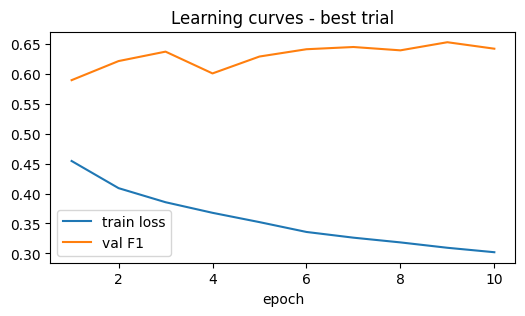

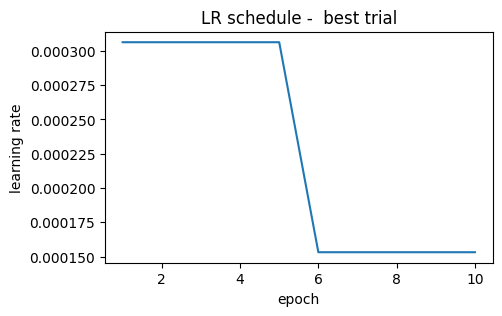

In [12]:
import matplotlib.pyplot as plt, pandas as pd

best = study.best_trial
epochs = range(1, len(best.user_attrs["lr_curve"]) + 1)

plt.figure(figsize=(6, 3))
plt.plot(epochs, best.user_attrs["train_loss_curve"], label="train loss")
plt.plot(epochs, best.user_attrs["val_f1_curve"], label="val F1")
plt.xlabel("epoch")
plt.legend()
plt.title("Learning curves - best trial")
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(epochs, best.user_attrs["lr_curve"])
plt.xlabel("epoch")
plt.ylabel("learning rate")
plt.title("LR schedule -  best trial")
plt.show()

## 4. Evaluate model on test set

In [13]:
# -- Rebuild the model with params and also the test df
test_df = SUPER["test_df"]

best = study.best_trial

ckpt = best.user_attrs["ckpt"]  # "gru_ckpts/trial_17.pt"

feature_key = best.user_attrs["features"]
if feature_key == "all_numeric":
    cols = ALL_NUMERIC_COLS
else:
    cols = FEATURE_SETS[feature_key]
WIN, S = best.user_attrs["win_len"], best.user_attrs["stride"]

# rebuild windows only for test
X_te, y_te = build_windows(test_df, WIN, S, cols)
test_loader = DataLoader(
    TensorDataset(torch.tensor(X_te), torch.tensor(y_te)[:, None]),
    batch_size=256,
    shuffle=False,
)

model = GRUClassifier(
    n_feats=X_te.shape[2],
    hidden=best.params["hidden"],
    num_layers=best.params["layers"],
    dropout=best.params["drop"],
).to(DEVICE)
model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
model.eval()

GRUClassifier(
  (gru): GRU(17, 64, num_layers=3, batch_first=True, dropout=0.2)
  (head): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)

Evaluation

In [14]:
all_pred, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(DEVICE))
        all_pred.extend((torch.sigmoid(logits) > 0.5).cpu().numpy().ravel())
        all_true.extend(yb.numpy().ravel())
y_pred = np.array(all_pred, dtype=int)
y_true = np.array(all_true, dtype=int)

Metrics

In [15]:
cm = confusion_matrix(y_true, y_pred)  # [[TN FP] [FN TP]]
TN, FP, FN, TP = cm.ravel()

acc = accuracy_score(y_true, y_pred)
recall = TP / (TP + FN + 1e-12)  # sensitivity / TPR
spec = TN / (TN + FP + 1e-12)  # specificity / TNR
prec = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion matrix (rows: true, cols: pred)")
print(cm, "\n")
print(f"Accuracy     : {acc :.3f}")
print(f"Recall (TPR) : {recall :.3f}")
print(f"Specificity  : {spec :.3f}")
print(f"Precision    : {prec :.3f}")
print(f"F1-score     : {f1 :.3f}")

Confusion matrix (rows: true, cols: pred)
[[10204  3192]
 [ 2226  4193]] 

Accuracy     : 0.727
Recall (TPR) : 0.653
Specificity  : 0.762
Precision    : 0.568
F1-score     : 0.608


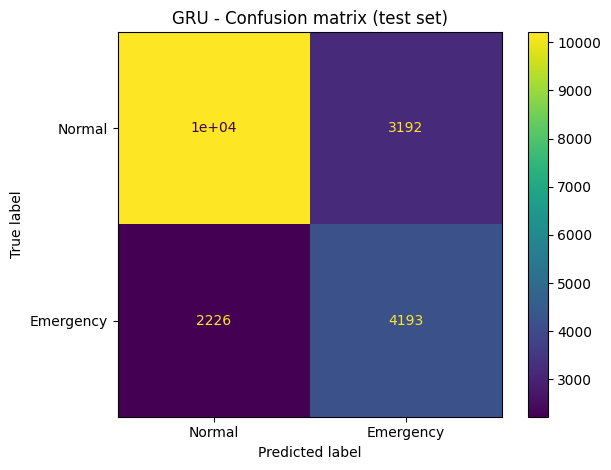

In [16]:
fig1, ax1 = plt.subplots()
ConfusionMatrixDisplay(cm, display_labels=["Normal", "Emergency"]).plot(ax=ax1)
ax1.set_title("GRU - Confusion matrix (test set)")
plt.tight_layout()
plt.show()

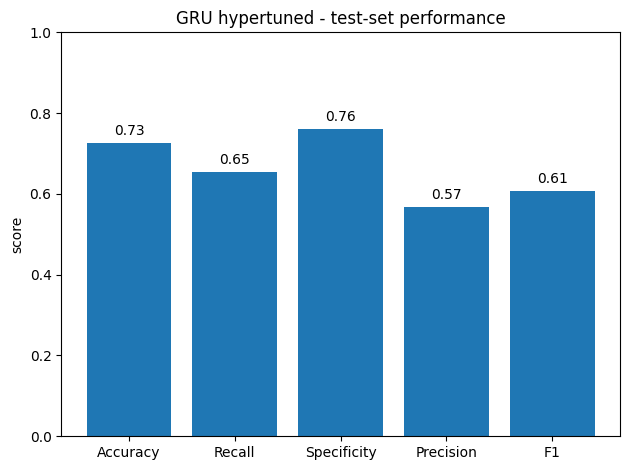

In [17]:
fig2, ax2 = plt.subplots()
metrics = [acc, recall, spec, prec, f1]
labels = ["Accuracy", "Recall", "Specificity", "Precision", "F1"]
ax2.bar(labels, metrics)
ax2.set_ylim(0, 1)
ax2.set_ylabel("score")
ax2.set_title("GRU hypertuned - test-set performance")
for idx, v in enumerate(metrics):  # annotate bars
    ax2.text(idx, v + 0.02, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.show()